## Importing Libraries and Dataset

In [ ]:
# Step 1: Importing the Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import os
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

!pip install optuna
import optuna

!pip install scikit-fuzzy
import skfuzzy as fuzz

# Step 2: Mount Google Drive and Upload kaggle.json
from google.colab import files

# Upload kaggle.json file (you can manually upload it from your local system)
files.upload()

# Step 3: Make a directory for Kaggle configuration and move the json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the Driver Drowsiness Dataset from Kaggle
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd

# Unzip the dataset
!unzip /content/driver-drowsiness-dataset-ddd.zip -d /content/drowsiness_data

!ls /content/drowsiness_data


# Verify if images are present in the Drowsy and Non Drowsy folders
drowsy_dir = os.path.join('/content/drowsiness_data/Driver Drowsiness Dataset (DDD)', 'Drowsy')
non_drowsy_dir = os.path.join('/content/drowsiness_data/Driver Drowsiness Dataset (DDD)', 'Non Drowsy')

print(f"Drowsy images: {len(os.listdir(drowsy_dir))}")
print(f"Non Drowsy images: {len(os.listdir(non_drowsy_dir))}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 20.7 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0092.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0093.png  
  inflating: /content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0094.png  
  inflating: /conte

## Image Metric Function

In [ ]:
# Define calculate_image_metrics function
def calculate_image_metrics(image):
    if image is None:
        return None
    # Ensure the image is converted to grayscale for certain metrics
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate metrics
    brightness = np.mean(gray)
    contrast = np.std(gray)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()  # Laplacian for sharpness
    avg_color = image.mean(axis=(0, 1))  # Average color in BGR format
    saturation = np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 1])  # Saturation from HSV

    # Return as a fixed-size list
    return [brightness, contrast, sharpness, avg_color[0], avg_color[1], avg_color[2], saturation]

### Image Shape

In [ ]:
# Directories for images
drowsy_dir = '/content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Drowsy'
non_drowsy_dir = '/content/drowsiness_data/Driver Drowsiness Dataset (DDD)/Non Drowsy'

# Initialize lists for metrics
drowsy_metrics = []
non_drowsy_metrics = []

# Function to process images in a directory
def process_images_in_directory(directory, metrics_list):
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)

        # Calculate metrics and add to list if valid
        metrics = calculate_image_metrics(image)
        if metrics is not None:
            metrics_list.append(metrics)
        else:
            print(f"Skipping image {filename} due to loading issues.")

# Process both Drowsy and Non-Drowsy images
process_images_in_directory(drowsy_dir, drowsy_metrics)
process_images_in_directory(non_drowsy_dir, non_drowsy_metrics)

# Convert to numpy arrays for analysis
drowsy_metrics = np.array(drowsy_metrics)
non_drowsy_metrics = np.array(non_drowsy_metrics)

print("Drowsy metrics shape:", drowsy_metrics.shape)
print("Non-drowsy metrics shape:", non_drowsy_metrics.shape)

Drowsy metrics shape: (22348, 7)
Non-drowsy metrics shape: (19445, 7)


### Calculating Statistics (Mean, Standard Deviation, Variance, T-tests)

In [ ]:
from scipy.stats import ttest_ind
# Metric names for reference
metrics_labels = ['Average Color (RGB)', 'Brightness', 'Contrast', 'Sharpness', 'Histogram Balance', 'Saturation']

# Calculate means and t-tests
for i, label in enumerate(metrics_labels):
    drowsy_values = drowsy_metrics[:, i]
    non_drowsy_values = non_drowsy_metrics[:, i]

    # Calculate mean and standard deviation
    mean_drowsy = np.mean(drowsy_values)
    mean_non_drowsy = np.mean(non_drowsy_values)
    std_drowsy = np.std(drowsy_values)
    std_non_drowsy = np.std(non_drowsy_values)

    # Perform t-test
    t_stat, p_value = ttest_ind(drowsy_values, non_drowsy_values, equal_var=False)

    print(f"\nMetric: {label}")
    print(f"Drowsy - Mean: {mean_drowsy:.2f}, Std: {std_drowsy:.2f}")
    print(f"Non-Drowsy - Mean: {mean_non_drowsy:.2f}, Std: {std_non_drowsy:.2f}")
    print(f"T-test - T-Statistic: {t_stat:.2f}, P-value: {p_value:.5f}")

    # Interpretation based on p-value
    if p_value < 0.05:
        print("Significant difference between Drowsy and Non-Drowsy images.")
    else:
        print("No significant difference found.")



Metric: Average Color (RGB)
Drowsy - Mean: 100.06, Std: 22.92
Non-Drowsy - Mean: 110.80, Std: 19.30
T-test - T-Statistic: -51.98, P-value: 0.00000
Significant difference between Drowsy and Non-Drowsy images.

Metric: Brightness
Drowsy - Mean: 51.42, Std: 12.22
Non-Drowsy - Mean: 55.09, Std: 10.71
T-test - T-Statistic: -32.71, P-value: 0.00000
Significant difference between Drowsy and Non-Drowsy images.

Metric: Contrast
Drowsy - Mean: 112.86, Std: 92.81
Non-Drowsy - Mean: 132.53, Std: 90.26
T-test - T-Statistic: -21.94, P-value: 0.00000
Significant difference between Drowsy and Non-Drowsy images.

Metric: Sharpness
Drowsy - Mean: 81.51, Std: 24.24
Non-Drowsy - Mean: 90.91, Std: 18.45
T-test - T-Statistic: -44.92, P-value: 0.00000
Significant difference between Drowsy and Non-Drowsy images.

Metric: Histogram Balance
Drowsy - Mean: 92.04, Std: 23.89
Non-Drowsy - Mean: 103.09, Std: 19.53
T-test - T-Statistic: -52.01, P-value: 0.00000
Significant difference between Drowsy and Non-Drowsy 

### Plotting Metrics

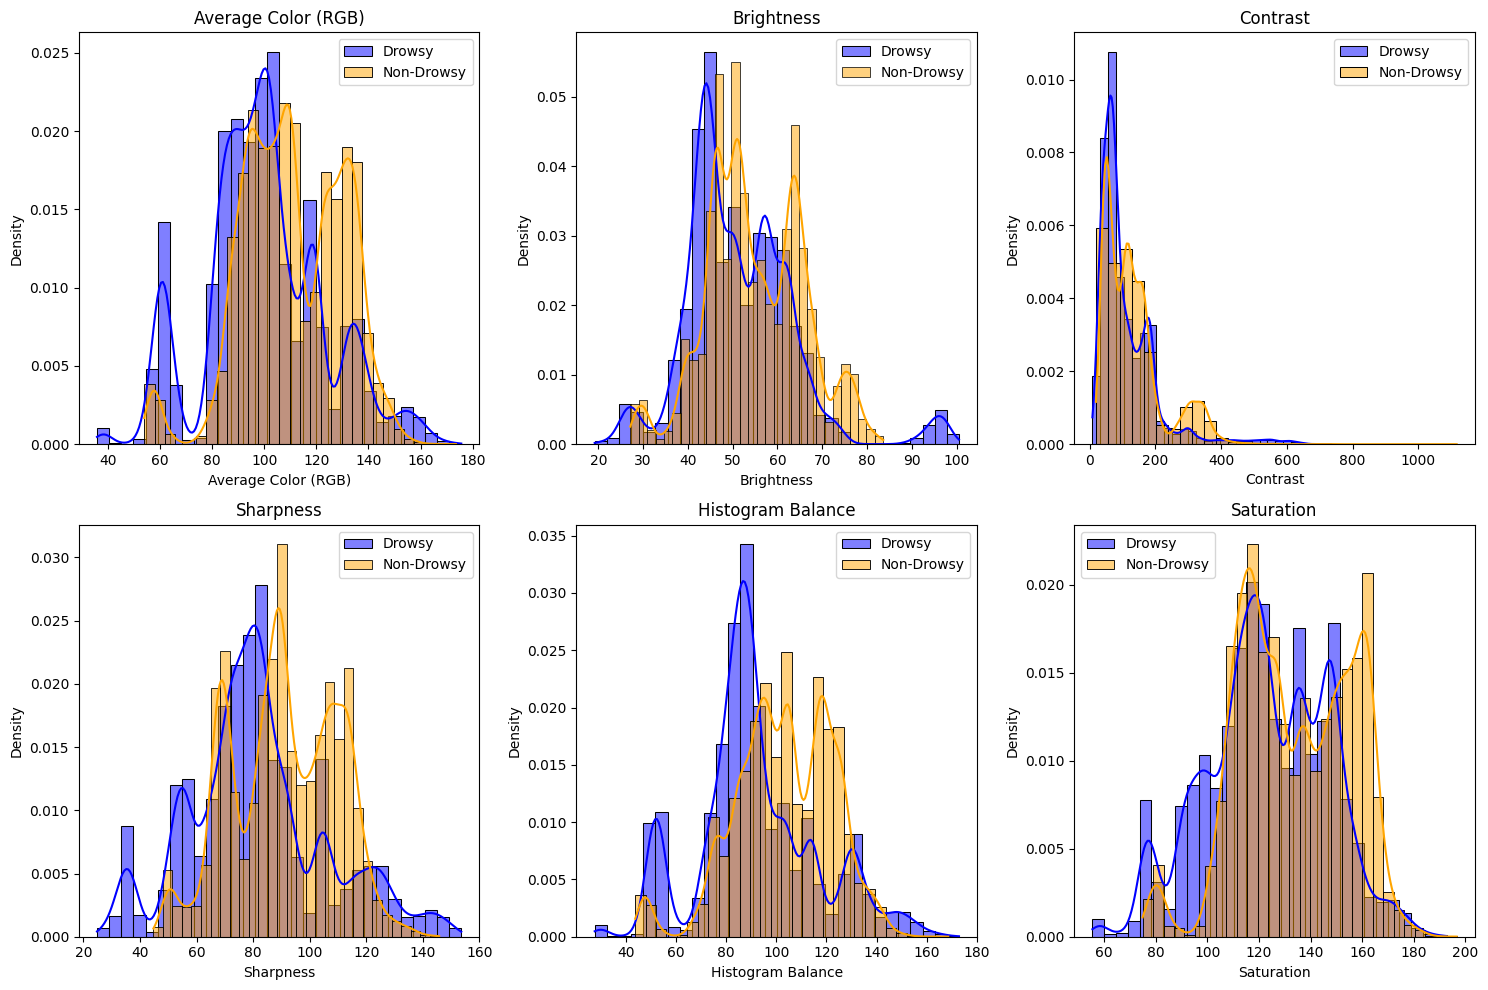

In [ ]:
plt.figure(figsize=(15, 10))
for i, label in enumerate(metrics_labels):
    plt.subplot(2, 3, i+1)
    sns.histplot(drowsy_metrics[:, i], color="blue", label="Drowsy", kde=True, stat="density", bins=30)
    sns.histplot(non_drowsy_metrics[:, i], color="orange", label="Non-Drowsy", kde=True, stat="density", bins=30)
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


## Normalization

In [ ]:
#Applying normalization
import cv2
import numpy as np

# Function to normalize brightness and contrast
def normalize_image(image):
    # Convert to YUV color space
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    # Histogram equalization on the Y channel
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    # Convert back to RGB
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

# Apply normalization to all images
drowsy_normalized = [normalize_image(cv2.imread(os.path.join(drowsy_dir, img))) for img in os.listdir(drowsy_dir)]
non_drowsy_normalized = [normalize_image(cv2.imread(os.path.join(non_drowsy_dir, img))) for img in os.listdir(non_drowsy_dir)]


### Histogram Matching

In [ ]:
import cv2
import os
import numpy as np

# Function for histogram matching with a single reference image
def match_histogram(image, reference):
    # Convert images to LAB color space for better luminance matching
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    reference_lab = cv2.cvtColor(reference, cv2.COLOR_RGB2LAB)

    # Histogram matching on each channel
    matched_channels = []
    for i in range(3):  # L, A, B channels
        hist, bins = np.histogram(reference_lab[:, :, i].ravel(), 256, [0, 256])
        hist_image, bins_image = np.histogram(image_lab[:, :, i].ravel(), 256, [0, 256])

        # Calculate cumulative distribution
        cdf_reference = hist.cumsum() / hist.sum()
        cdf_image = hist_image.cumsum() / hist_image.sum()

        # Map image channel based on reference
        matched_channel = np.interp(image_lab[:, :, i].ravel(), bins_image[:-1], np.interp(cdf_image, cdf_reference, bins[:-1]))
        matched_channels.append(matched_channel.reshape(image_lab[:, :, i].shape))

    # Merge channels and convert back to RGB
    matched_lab = cv2.merge(matched_channels)
    matched_rgb = cv2.cvtColor(matched_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
    return matched_rgb

# Load a single reference image for histogram matching
reference_image_path = os.path.join(non_drowsy_dir, os.listdir(non_drowsy_dir)[0])
reference_image = cv2.imread(reference_image_path)

# Directories to save processed images
os.makedirs("drowsy_matched", exist_ok=True)
os.makedirs("non_drowsy_matched", exist_ok=True)

# Apply histogram matching for drowsy images one by one
for img_name in os.listdir(drowsy_dir):
    img_path = os.path.join(drowsy_dir, img_name)
    image = cv2.imread(img_path)
    matched_image = match_histogram(image, reference_image)
    cv2.imwrite(f"drowsy_matched/{img_name}", matched_image)

# Apply histogram matching for non-drowsy images one by one
for img_name in os.listdir(non_drowsy_dir):
    img_path = os.path.join(non_drowsy_dir, img_name)
    image = cv2.imread(img_path)
    matched_image = match_histogram(image, reference_image)
    cv2.imwrite(f"non_drowsy_matched/{img_name}", matched_image)


### T-test after Normalization

In [ ]:
import numpy as np
import cv2
import os
from scipy.stats import ttest_ind

# Define a function to calculate brightness and contrast for a list of images
def get_metrics(image_list):
    brightness_values = []
    contrast_values = []

    for img in image_list:
        # Convert image to grayscale for brightness and contrast calculation
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Brightness: mean pixel value
        brightness = np.mean(gray_img)
        brightness_values.append(brightness)

        # Contrast: standard deviation of pixel values
        contrast = np.std(gray_img)
        contrast_values.append(contrast)

    return brightness_values, contrast_values

# Load processed images from "drowsy_matched" and "non_drowsy_matched" directories
drowsy_matched = [cv2.imread(os.path.join("drowsy_matched", img)) for img in os.listdir("drowsy_matched")]
non_drowsy_matched = [cv2.imread(os.path.join("non_drowsy_matched", img)) for img in os.listdir("non_drowsy_matched")]

# Calculate metrics for matched images
drowsy_brightness, drowsy_contrast = get_metrics(drowsy_matched)
non_drowsy_brightness, non_drowsy_contrast = get_metrics(non_drowsy_matched)

# Perform T-tests on brightness and contrast
# Brightness T-test after normalization
t_stat_brightness, p_val_brightness = ttest_ind(drowsy_brightness, non_drowsy_brightness)
print("Brightness T-test after normalization - T-statistic:", t_stat_brightness, ", P-value:", p_val_brightness)

# Contrast T-test after normalization
t_stat_contrast, p_val_contrast = ttest_ind(drowsy_contrast, non_drowsy_contrast)
print("Contrast T-test after normalization - T-statistic:", t_stat_contrast, ", P-value:", p_val_contrast)


Brightness T-test after normalization - T-statistic: 28.61700918684791 , P-value: 2.1869570598754402e-178
Contrast T-test after normalization - T-statistic: 16.796865706832598 , P-value: 4.1471440367085e-63


## Feature Extraction

In [ ]:
#Extracting image level features
import numpy as np
import cv2
import os

# Directories with matched images
drowsy_dir = "drowsy_matched"
non_drowsy_dir = "non_drowsy_matched"

# Function to extract features: brightness, contrast, and average color
def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    brightness = np.mean(gray)
    contrast = np.std(gray)
    avg_color = np.mean(image, axis=(0, 1))  # Average color for each RGB channel
    return [brightness, contrast] + avg_color.tolist()

# Prepare dataset
features = []
labels = []

for img_name in os.listdir(drowsy_dir):
    image = cv2.imread(os.path.join(drowsy_dir, img_name))
    features.append(extract_features(image))
    labels.append(1)  # Label for "drowsy"

for img_name in os.listdir(non_drowsy_dir):
    image = cv2.imread(os.path.join(non_drowsy_dir, img_name))
    features.append(extract_features(image))
    labels.append(0)  # Label for "non-drowsy"

features = np.array(features)
labels = np.array(labels)


### Preprocessing Images

In [ ]:
# Paths to the directories
drowsy_path = '/content/drowsy_matched'
non_drowsy_path = '/content/non_drowsy_matched'

# Function to load and preprocess images
def load_images_from_folder(folder, label, image_size=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)  # Resize to fixed size
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(label)
    return images, labels

In [ ]:
# Ensure that TensorFlow is using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is being used!")
else:
    print("GPU is not available, using CPU.")

GPU is being used!


## Dataset Splitting

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Paths to the datasets
drowsy_path = '/content/drowsy_matched'
non_drowsy_path = '/content/non_drowsy_matched'

# Load the datasets
train_dataset = image_dataset_from_directory(
    '/content',  # Parent directory that contains your 'drowsy_matched' and 'non_drowsy_matched' directories
    labels='inferred',
    label_mode='binary',  # binary classification: drowsy vs. non-drowsy
    class_names=['non_drowsy_matched', 'drowsy_matched'],  # Class names should match folder names
    image_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123,
)

val_dataset = image_dataset_from_directory(
    '/content',  # Parent directory that contains your 'drowsy_matched' and 'non_drowsy_matched' directories
    labels='inferred',
    label_mode='binary',
    class_names=['non_drowsy_matched', 'drowsy_matched'],  # Class names should match folder names
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123,
)

# Check the dataset structure
class_names = train_dataset.class_names
print("Class names:", class_names)


Found 41793 files belonging to 2 classes.
Using 33435 files for training.
Found 41793 files belonging to 2 classes.
Using 8358 files for validation.
Class names: ['non_drowsy_matched', 'drowsy_matched']


## Baseline Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the features into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the validation set
y_pred = clf.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9157793994496949
Precision: 0.921012101210121
Recall: 0.9238578680203046
F1 Score: 0.9224327897752314


### Hyperparameter Tuning

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters for tuning
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Train the model
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Evaluate model
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

# Create Optuna study to optimize the hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value}")

[I 2024-11-11 01:31:41,632] A new study created in memory with name: no-name-cd82d8ff-67e8-45f5-971a-c483d8f5a8ad
[I 2024-11-11 01:31:41,815] Trial 0 finished with value: 0.8320373250388803 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8320373250388803.
[I 2024-11-11 01:31:41,877] Trial 1 finished with value: 0.7064242134226583 and parameters: {'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.8320373250388803.
[I 2024-11-11 01:31:42,163] Trial 2 finished with value: 0.9132671372173705 and parameters: {'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9132671372173705.
[I 2024-11-11 01:31:42,461] Trial 3 finished with value: 0.9147027156358416 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9147027156358416.
[I 2024-11-11 01:31:42,728] Trial 4 finished with value: 0.90

Best Hyperparameters: {'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 5}
Best Accuracy: 0.9222395023328149


### Training Model and Plotting Metrics over Trials

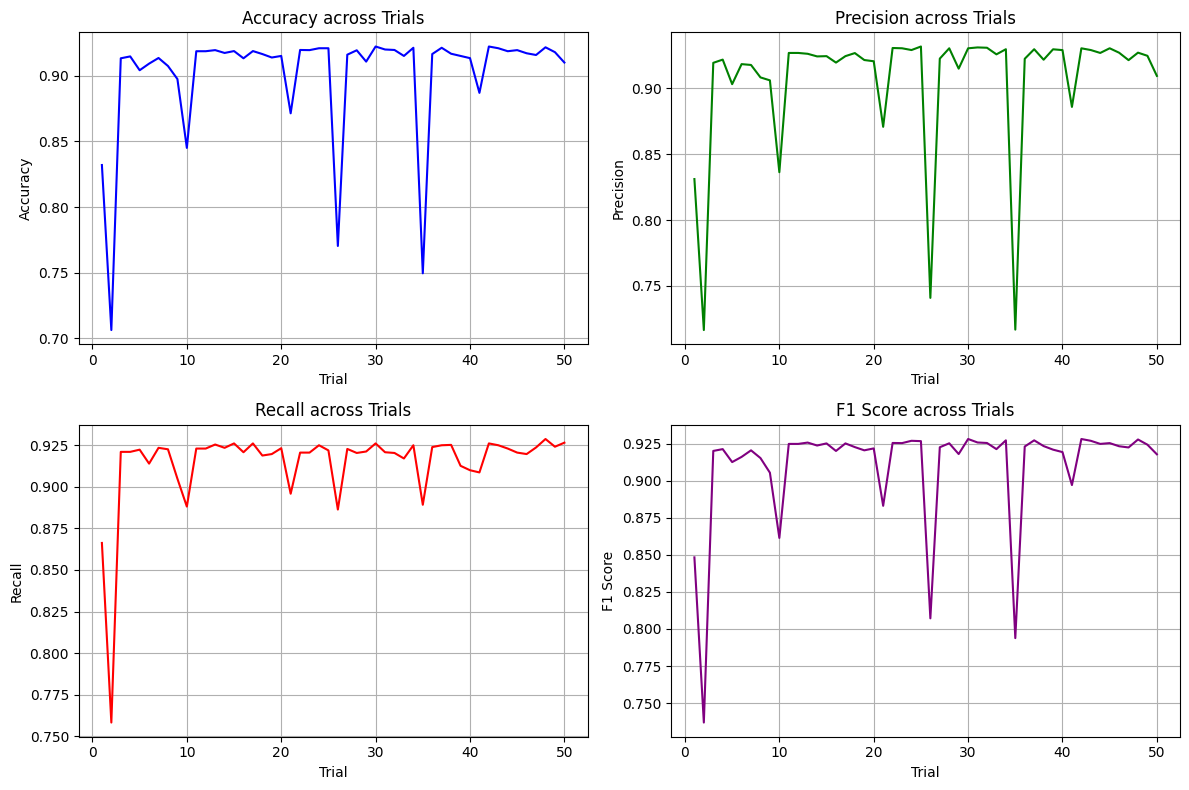

Accuracy: 0.9100370857758106
Precision: 0.909248429716266
Recall: 0.926506290002207
F1 Score: 0.9177962396152164


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# List to store the metrics for each trial
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Iterate through the trials to get the performance for each trial
for trial in study.trials:
    # Extract the best hyperparameters
    best_params = trial.params
    clf_trial = DecisionTreeClassifier(
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )

    # Train the model
    clf_trial.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = clf_trial.predict(X_val)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Store the results
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Plotting the metrics across trials
plt.figure(figsize=(12, 8))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy', color='blue')
plt.title('Accuracy across Trials')
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.grid(True)

# Precision Plot
plt.subplot(2, 2, 2)
plt.plot(range(1, len(precisions) + 1), precisions, label='Precision', color='green')
plt.title('Precision across Trials')
plt.xlabel('Trial')
plt.ylabel('Precision')
plt.grid(True)

# Recall Plot
plt.subplot(2, 2, 3)
plt.plot(range(1, len(recalls) + 1), recalls, label='Recall', color='red')
plt.title('Recall across Trials')
plt.xlabel('Trial')
plt.ylabel('Recall')
plt.grid(True)

# F1 Score Plot
plt.subplot(2, 2, 4)
plt.plot(range(1, len(f1_scores) + 1), f1_scores, label='F1 Score', color='purple')
plt.title('F1 Score across Trials')
plt.xlabel('Trial')
plt.ylabel('F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

### Confusion Matrix

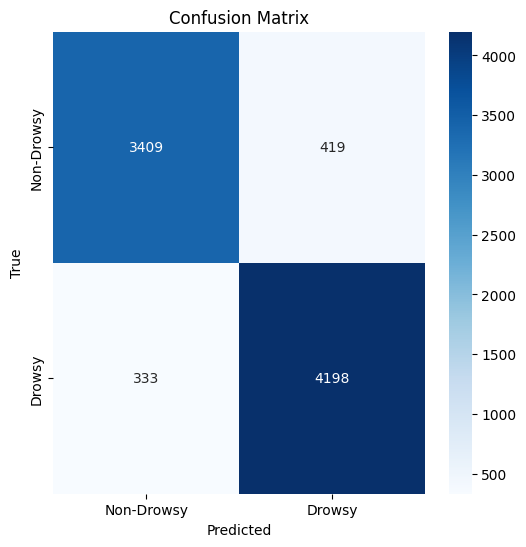

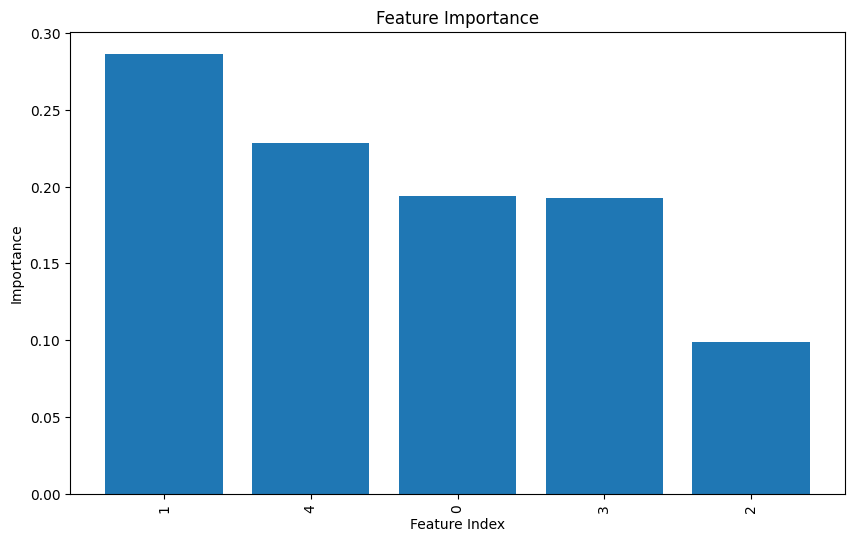

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Drowsy', 'Drowsy'], yticklabels=['Non-Drowsy', 'Drowsy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize feature importance (if necessary)
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), indices, rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

## Fuzzy Logic

In [ ]:
# Define fuzzy inference system based on features
def fuzzy_inference(features):
    # Assuming the features are brightness, contrast, and average color
    brightness, contrast, avg_red, avg_green, avg_blue = features

    # Define the membership functions (Example: brightness, contrast, color)
    x_brightness = np.arange(0, 256, 1)
    x_contrast = np.arange(0, 256, 1)
    x_color = np.arange(0, 256, 1)

    # Fuzzy membership functions for brightness, contrast, and color
    low_brightness = fuzz.trapmf(x_brightness, [0, 0, 50, 100])
    medium_brightness = fuzz.trimf(x_brightness, [50, 150, 200])
    high_brightness = fuzz.trapmf(x_brightness, [150, 200, 255, 255])

    low_contrast = fuzz.trapmf(x_contrast, [0, 0, 50, 100])
    high_contrast = fuzz.trapmf(x_contrast, [100, 150, 255, 255])

    low_color = fuzz.trapmf(x_color, [0, 0, 50, 100])
    high_color = fuzz.trapmf(x_color, [100, 150, 255, 255])

    # Compute membership values for the features
    brightness_low = fuzz.interp_membership(x_brightness, low_brightness, brightness)
    brightness_medium = fuzz.interp_membership(x_brightness, medium_brightness, brightness)
    brightness_high = fuzz.interp_membership(x_brightness, high_brightness, brightness)

    contrast_low = fuzz.interp_membership(x_contrast, low_contrast, contrast)
    contrast_high = fuzz.interp_membership(x_contrast, high_contrast, contrast)

    color_low = fuzz.interp_membership(x_color, low_color, avg_red)
    color_high = fuzz.interp_membership(x_color, high_color, avg_red)

    # Combine the fuzzy results using rules
    drowsy_score = brightness_low * 0.5 + brightness_high * 0.5
    moderately_drowsy_score = contrast_low * 0.4 + contrast_high * 0.6
    non_drowsy_score = color_low * 0.7 + color_high * 0.3

    # Final decision based on fuzzy outputs
    final_decision = drowsy_score + moderately_drowsy_score + non_drowsy_score
    return np.clip(final_decision, 0, 1)

### Fuzzy Logic with Decision Tree

In [ ]:
# Decision Tree model with fuzzy logic integration
class FuzzyDecisionTree:
    def __init__(self, tree_model, fuzzy_model):
        self.tree_model = tree_model
        self.fuzzy_model = fuzzy_model

    def predict(self, X):
        # Predict with the decision tree
        tree_preds = self.tree_model.predict(X)

        # Fuzzy inference prediction
        fuzzy_preds = np.array([self.fuzzy_model(x) for x in X])

        # Combine both outputs (tree and fuzzy) - use average for final decision
        combined_preds = (tree_preds + fuzzy_preds) / 2
        return np.round(combined_preds)


### Training Setup and Hypeparameter Tuning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Metrics history to store performance for each trial
metrics_history = {
    'trial': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'confusion_matrix': []  # To store confusion matrix
}

# Optuna objective function for hyperparameter tuning
def objective(trial):
    # Define hyperparameters for tuning
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Train the Decision Tree model
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Integrate fuzzy model
    fuzzy_model = fuzzy_inference
    fuzzy_tree_model = FuzzyDecisionTree(clf, fuzzy_model)

    # Evaluate model
    y_pred = fuzzy_tree_model.predict(X_val)

    # Calculate performance metrics with zero_division to avoid ill-defined scores
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=1)  # Handle zero division
    recall = recall_score(y_val, y_pred, zero_division=1)        # Handle zero division
    f1 = f1_score(y_val, y_pred, zero_division=1)                # Handle zero division

    # Compute confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Store metrics for the current trial
    metrics_history['trial'].append(trial.number)
    metrics_history['accuracy'].append(accuracy)
    metrics_history['precision'].append(precision)
    metrics_history['recall'].append(recall)
    metrics_history['f1_score'].append(f1)
    metrics_history['confusion_matrix'].append(cm)  # Store confusion matrix


    # Return the accuracy to Optuna
    return accuracy


In [ ]:
# Create Optuna study to optimize the hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# After optimization, print the best hyperparameters and accuracy
print(f"Best Hyperparameters: {study.best_params}")
print(f"Best Accuracy: {study.best_value}")

[I 2024-11-11 01:34:42,264] A new study created in memory with name: no-name-016fb447-8c32-4c27-a809-26f1c9b11805
[I 2024-11-11 01:34:48,177] Trial 0 finished with value: 0.9185309247517646 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9185309247517646.
[I 2024-11-11 01:34:53,795] Trial 1 finished with value: 0.7165928938868286 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9185309247517646.
[I 2024-11-11 01:34:59,490] Trial 2 finished with value: 0.9157793994496949 and parameters: {'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.9185309247517646.
[I 2024-11-11 01:35:05,194] Trial 3 finished with value: 0.9070462974039957 and parameters: {'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.9185309247517646.
[I 2024-11-11 01:35:11,096] Trial 4 finished with value: 0.

Best Hyperparameters: {'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 7}
Best Accuracy: 0.9212824500538342


### Plotting Metrics

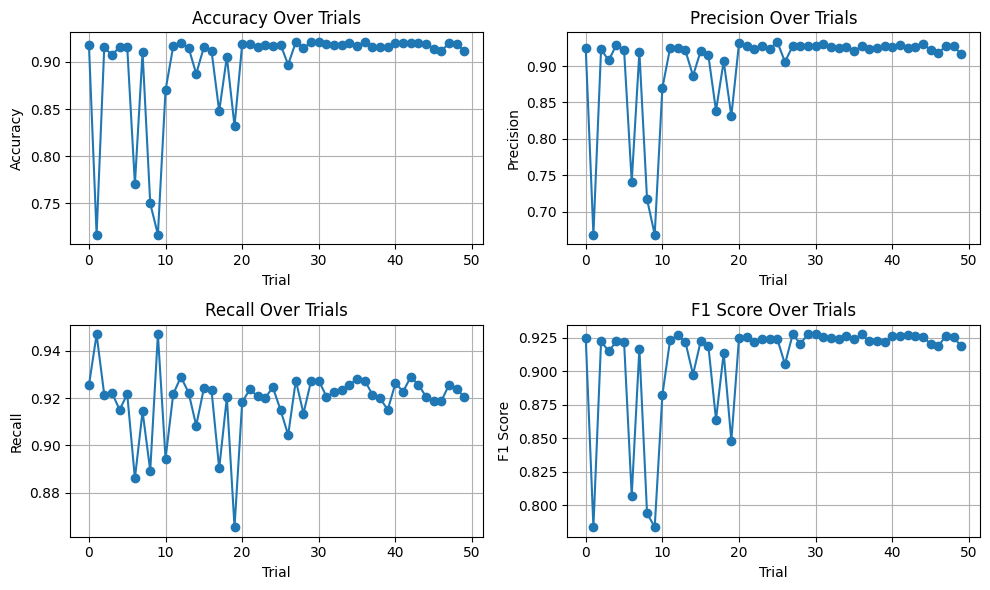

In [ ]:
# Plot the metrics over the trials
plt.figure(figsize=(10, 6))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(metrics_history['trial'], metrics_history['accuracy'], marker='o', label='Accuracy')
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Trials')
plt.grid(True)

# Plot Precision
plt.subplot(2, 2, 2)
plt.plot(metrics_history['trial'], metrics_history['precision'], marker='o', label='Precision')
plt.xlabel('Trial')
plt.ylabel('Precision')
plt.title('Precision Over Trials')
plt.grid(True)

# Plot Recall
plt.subplot(2, 2, 3)
plt.plot(metrics_history['trial'], metrics_history['recall'], marker='o', label='Recall')
plt.xlabel('Trial')
plt.ylabel('Recall')
plt.title('Recall Over Trials')
plt.grid(True)

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.plot(metrics_history['trial'], metrics_history['f1_score'], marker='o', label='F1 Score')
plt.xlabel('Trial')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Trials')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

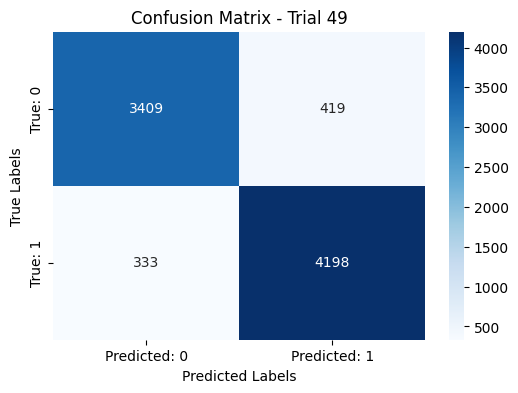

In [ ]:
    # Plot confusion matrix using Seaborn heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted: 0', 'Predicted: 1'],
                yticklabels=['True: 0', 'True: 1'])
    plt.title(f'Confusion Matrix - Trial {trial.number}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()